In [1]:
import pyuvdata
import numpy as np
import matplotlib.pyplot as plt

In [2]:
path = '/Users/ruby/Astro/LWA_pyuvsim_simulations'
sim_version = '100ms_sim'
filename = f'OVRO-LWA_{sim_version}_results.uvfits'

In [3]:
uv_unphased = pyuvdata.UVData()
uv_unphased.read_uvfits(f"{path}/{filename}")
uv_unphased.unphase_to_drift()

Fixing auto-correlations to be be real-only, after some imaginary values were detected in data_array.


In [4]:
times = sorted(list(set(uv_unphased.time_array)))
center_time = times[int(np.floor(len(times)/2))]
uv_phased = uv_unphased.copy()
uv_phased.phase_to_time(center_time)

In [5]:
uv_center_time = uv_unphased.copy()
uv_center_time.select(times=center_time)
uv_center_time.phase_to_time(center_time)

In [6]:
# Ensure ordering matches
if np.max(np.abs(uv_unphased.baseline_array - uv_phased.baseline_array)) > 0.0:
    uv_unphased.reorder_blts()
    uv_phased.reorder_blts()
if np.max(np.abs(uv_unphased.freq_array - uv_phased.freq_array)) > 0.0:
    uv_unphased.reorder_freqs(channel_order="freq")
    uv_phased.reorder_freqs(channel_order="freq")

In [7]:
uv_phase_vals = uv_unphased.copy()
uv_phase_vals.data_array = uv_unphased.data_array/uv_phased.data_array
uv_phase_vals.downsample_in_time(n_times_to_avg=uv_phase_vals.Ntimes, allow_drift=True)

Data are in drift mode and allow_drift is True, so resampling will be done without phasing.


In [8]:
uv_unphased.downsample_in_time(n_times_to_avg=uv_unphased.Ntimes, allow_drift=True)

Data are in drift mode and allow_drift is True, so resampling will be done without phasing.


In [9]:
uv_corrected = uv_unphased.copy()
uv_corrected.data_array /= uv_phase_vals.data_array

In [10]:
uv_corrected.phase_to_time(center_time)

In [11]:
uv_phased.downsample_in_time(n_times_to_avg=uv_phased.Ntimes)

In [12]:
nbins = 40
bin_edges = np.linspace(0, 2400, num=nbins+1)

In [13]:
def histogram_bls(uv, bin_edges):
    nbins = len(bin_edges)-1
    avg_amps = np.zeros(nbins, dtype=float)
    for bin_ind in range(nbins):
        bl_lengths = np.sqrt(np.sum(uv.uvw_array**2, axis=1))
        use_bls = np.intersect1d(np.where(bl_lengths>bin_edges[bin_ind])[0], np.where(bl_lengths<bin_edges[bin_ind+1])[0])
        if len(use_bls) > 0:
            avg_amps_val = np.mean(np.abs(uv.data_array[use_bls, :, :, :]))
            avg_amps[bin_ind] = avg_amps_val
    return avg_amps

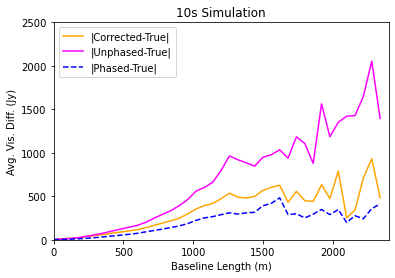

In [19]:
uv_correction_diff = uv_center_time.copy()
uv_correction_diff.data_array -= uv_corrected.data_array
correction_diff = histogram_bls(uv_correction_diff, bin_edges)

uv_unphased_diff = uv_center_time.copy()
uv_unphased_diff.data_array -= uv_unphased.data_array
unphased_diff = histogram_bls(uv_unphased_diff, bin_edges)

uv_phased_diff = uv_center_time.copy()
uv_phased_diff.data_array -= uv_phased.data_array
phased_diff = histogram_bls(uv_phased_diff, bin_edges)

plt.plot(bin_edges[:-1], correction_diff, color='orange')
plt.plot(bin_edges[:-1], unphased_diff, color='magenta')
plt.plot(bin_edges[:-1], phased_diff, '--', color='blue')

plt.xlabel("Baseline Length (m)")
plt.ylabel("Avg. Vis. Diff. (Jy)")
plt.xlim([0,np.max(bin_edges)])
plt.ylim([0,2500])
plt.title("10s Simulation")
plt.legend(['|Corrected-True|','|Unphased-True|','|Phased-True|'])
plt.savefig(f"{path}/{sim_version}_correction_plot.png", dpi=400, facecolor='white')
plt.show()

In [15]:
def calc_fractional_error(uv_in, uv_true, bin_edges):
    uv = uv_true.copy()
    uv.data_array -= uv_in.data_array
    
    nbins = len(bin_edges)-1
    avg_amps = np.zeros(nbins, dtype=float)
    for bin_ind in range(nbins):
        bl_lengths = np.sqrt(np.sum(uv.uvw_array**2, axis=1))
        use_bls = np.intersect1d(np.where(bl_lengths>bin_edges[bin_ind])[0], np.where(bl_lengths<bin_edges[bin_ind+1])[0])
        if len(use_bls) > 0:
            avg_amps_val = np.mean(np.abs(uv.data_array[use_bls, :, :, :]))/np.mean(np.abs(uv_true.data_array[use_bls, :, :, :]))
            avg_amps[bin_ind] = avg_amps_val
    return avg_amps

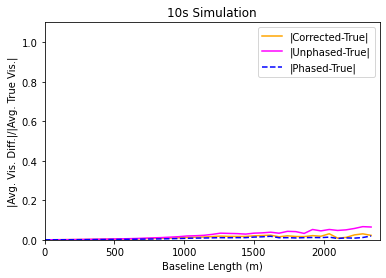

In [22]:
correction_diff = calc_fractional_error(uv_corrected, uv_center_time, bin_edges)

unphased_diff = calc_fractional_error(uv_unphased, uv_center_time, bin_edges)

phased_diff = calc_fractional_error(uv_phased, uv_center_time, bin_edges)

plt.plot(bin_edges[:-1], correction_diff, color='orange')
plt.plot(bin_edges[:-1], unphased_diff, color='magenta')
plt.plot(bin_edges[:-1], phased_diff, '--', color='blue')

plt.xlabel("Baseline Length (m)")
plt.ylabel("|Avg. Vis. Diff.|/|Avg. True Vis.|")
plt.xlim([0,np.max(bin_edges)])
plt.ylim([0,1.1])
plt.title("10s Simulation")
plt.legend(['|Corrected-True|','|Unphased-True|','|Phased-True|'])
plt.savefig(f"{path}/{sim_version}_frac_correction_plot.png", dpi=400, facecolor='white')
plt.show()

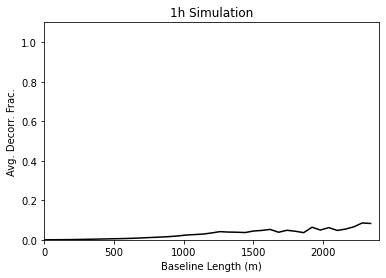

In [17]:
decorr_frac = uv_phase_vals.copy()
decorr_frac.data_array = 1.-uv_phase_vals.data_array
phase_vals = histogram_bls(decorr_frac, bin_edges)

plt.plot(bin_edges[:-1], phase_vals, color='black')

plt.xlabel("Baseline Length (m)")
plt.ylabel("Avg. Decorr. Frac.")
plt.xlim([0,np.max(bin_edges)])
plt.ylim([0,1.1])
plt.title("1h Simulation")
#plt.savefig(f"{path}/{sim_version}_correction_plot.png", dpi=400)
plt.show()

In [18]:
uv_corrected.write_uvfits(f"{path}/OVRO-LWA_{sim_version}_corrected.uvfits")

antnums_to_baseline: found antenna numbers > 256, using 2048 baseline indexing. Beware compatibility with CASA etc
Found antenna numbers > 256 in this data set. This is permitted by UVFITS standards, but may cause the `importuvfits` utility within CASA to crash. If attempting to use this data set in CASA, consider using the measurement set writer method (`write_ms`) instead.
